In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict,cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict,cross_val_score, train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, chi2
import os

In [2]:
print(os.listdir("../181101059"))

['.ipynb_checkpoints', '181101059.html', '181101059.ipynb', '181101059.pdf', '181101059_test.ipynb', 'model.pkl', 'preprocessing.pkl', 'requirements.txt', 'WA_Fn-UseC_-HR-Employee-Attrition.csv']


In [3]:
class ConvertingData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Target'] = X['Attrition'].apply(lambda x: 0 if x == 'No' else 1)
        X.drop(['EmployeeCount', 'StandardHours', 'Over18', 'Attrition'], axis=1,inplace=True)
        arr_cat = X.select_dtypes(include='object')
        dummy_col = [column for column in arr_cat if X[column].nunique() < 20]
        return pd.get_dummies(X, columns=dummy_col, drop_first=True, dtype='int64')

In [4]:
class ScalerData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        target = X["Target"]
        scaler = MinMaxScaler()
        scaled = list(X.columns)
        scaled.remove('Target')
        for col in scaled:
            X[col] = X[col].astype(float)
            X[[col]] = scaler.fit_transform(X[[col]])
        return X

In [5]:
class ChoosingKBest(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        target = X["Target"]
        X = X.drop(["Target"], axis=1)
        select = SelectKBest(score_func=chi2, k=5)
        X = select.fit_transform(X,target)
        X = pd.DataFrame(X)
        X["Target"] = target
        return X

In [6]:
model = pickle.load(open(
    r'../181101059/model.pkl', 'rb'))

In [7]:
pipeline = pickle.load(open(
    r'../181101059/preprocessing.pkl', 'rb'))

In [8]:
data = pd.read_csv("../181101059/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [9]:
data = pipeline.fit_transform(data)

In [10]:
data.head()

,0,1,2,3,4,Target
0,0.25,0.0,0.0,1.0,1.0,1
1,0.25,1.0,0.0,0.0,0.0,0
2,0.00,0.0,0.0,1.0,1.0,1
3,0.00,1.0,0.0,0.0,1.0,0
4,0.00,0.0,0.0,0.0,0.0,0


In [11]:
%%time
target = data["Target"]
data = data.loc[:, data.columns != 'Target']
scores_test = cross_val_score(model, data, target, scoring='accuracy', cv=5)
print(scores_test)

[0.8537415  0.85714286 0.84353741 0.84693878 0.8537415 ]
CPU times: total: 15.6 ms
Wall time: 24.6 ms


In [12]:
%%time
test_predict = cross_val_predict(model, data, target, cv=5)

CPU times: total: 15.6 ms
Wall time: 20.3 ms


In [13]:
target_list = target.tolist()

In [14]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(target_list, test_predict, 
                                    target_names= ["1","0"]))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.86      0.98      0.92      1233
           0       0.65      0.17      0.27       237

    accuracy                           0.85      1470
   macro avg       0.75      0.58      0.59      1470
weighted avg       0.83      0.85      0.81      1470



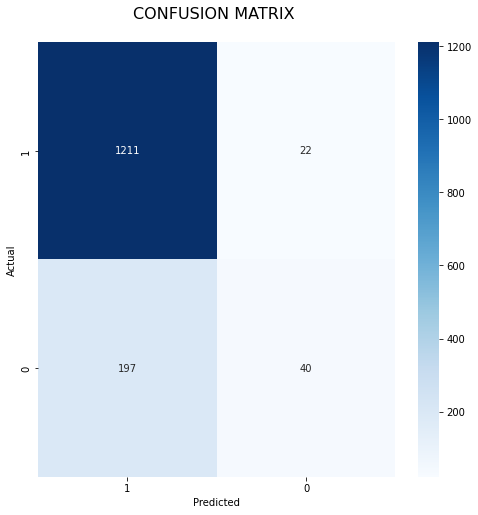

In [15]:
conf_mat = confusion_matrix(target_list, test_predict)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=["1","0"], 
            yticklabels=["1","0"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX \n", size=16);